<a href="https://colab.research.google.com/github/Ricardomanuel1/Maestria_Ciencia_de_Datos/blob/main/MACHINE%20LEARNING%20Y%20DEEP%20LEARNING/1_ClasificacionMLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Redes Neuronales MLP para Clasificación**

Basado en Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd Edition. Aurélien Géron. 2019

Librerías requeridas

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


**Funciones de Activación**

In [3]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

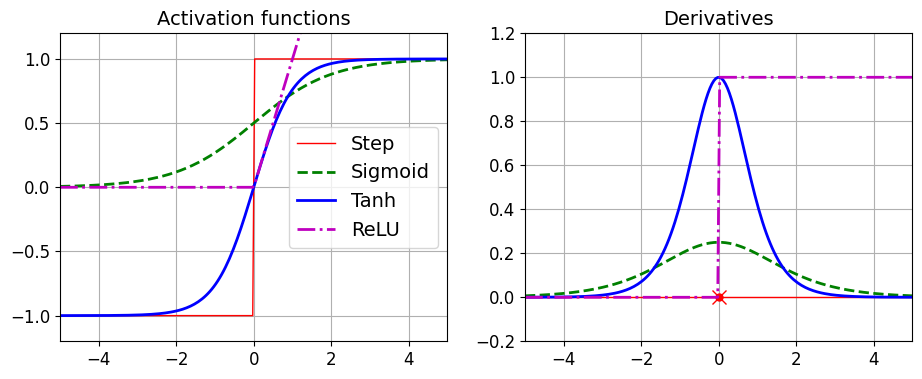

In [4]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

## **MLPs y Clasificación**

In [5]:
import tensorflow as tf
from tensorflow import keras

In [6]:
tf.__version__

'2.15.0'

In [7]:
#keras.__version__

**Dataset: MNIST Fashion**

El conjunto de datos MNIST de moda está incorporado en Keras.

El conjunto de datos ya está dividido entre un conjunto de entrenamiento y un conjunto de prueba, pero puede resultar útil dividir aún más el conjunto de entrenamiento para tener un conjunto de validación:

In [8]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


El conjunto de entrenamiento contiene 60.000 imágenes en escala de grises, cada una de 28x28 píxeles:


In [9]:
X_train_full.shape#hay 60 mil imagaenes en el conjunto de entrenamiento

(60000, 28, 28)

In [10]:
y_train_full.shape

(60000,)

Cada intensidad de píxel se representa como un byte (0 a 255):

In [11]:
X_train_full.dtype

dtype('uint8')

Dividamos el conjunto de entrenamiento completo en un conjunto de validación y un conjunto de entrenamiento (más pequeño). También reducimos las intensidades de los píxeles al rango 0-1 y las convertimos en flotantes, dividiéndolas por 255.

In [12]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

Se puede mostrar una imagen usando la función imshow() de Matplotlib, con un mapa de color 'binario':

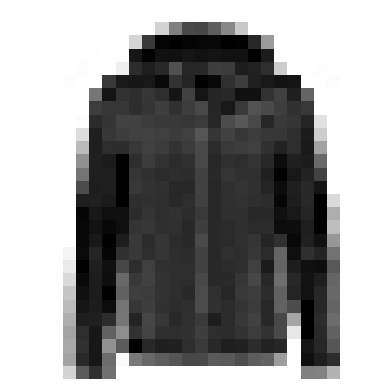

In [13]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

Las etiquetas son los ID de clase (representados como uint8), del 0 al 9:

In [14]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Aquí están los nombres de clases correspondientes:

In [18]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

La primera imagen del conjunto de entrenamiento es un abrigo:

In [19]:
class_names[y_train[0]]

'Coat'

El conjunto de validación contiene 5000 imágenes y el conjunto de prueba contiene 10 000 imágenes:

In [20]:
X_valid.shape

(5000, 28, 28)

In [24]:
X_train.shape#se tiene 55,000 imagenes,cada uno representado por una matriz de 28 filas y 28 columnas

(55000, 28, 28)

In [25]:
X_test.shape

(10000, 28, 28)

In [26]:
y_train.shape

(55000,)

Una muestra de las imágenes del conjunto de datos:

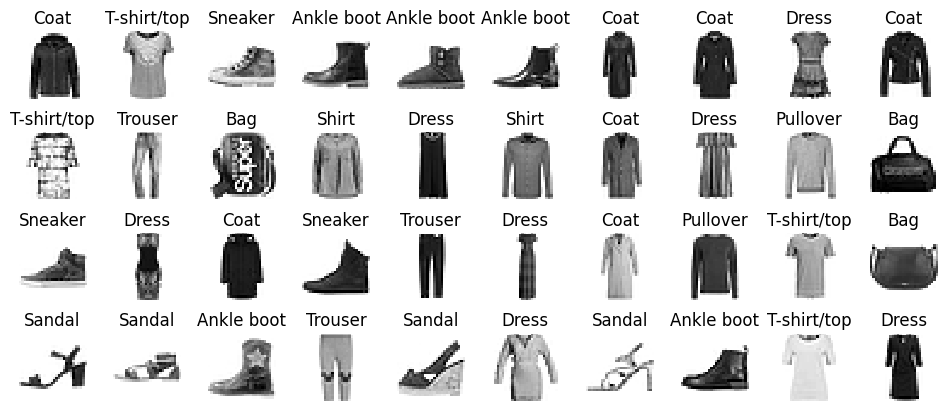

In [27]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):#0,1,2,3
    for col in range(n_cols):#0,1,2....9
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

##**Construcción del Modelo Secuencial**

Una forma:

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))#todas las matrices van a una sola fila
model.add(keras.layers.Dense(300, activation="relu"))#cada capa densa tiene su matriz de pesos y vallas
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))#la sorfmax transforma los 10 numeros de cero a 1

- La primera línea crea un modelo Sequential. La forma más simple en Keras para definir Redes Neuronales compuestas de un apilado de capas conectadas secuencialmente.
- La capa ``Flatten`` tiene el papel de convertircada imagen en un arreglo de 1D: recibe datos X, y hace un ``X.reshape(-1,28*28)``. Esta capa no tiene parámetros. Dado que es la primera capa debe especificarse el ``input_shape``, que no incluye el tamaño de batch.
- Se añade una oculta ``Dense`` con 300 neuronas. Usará ReLU como función de activación. Cada capa ``Dense``tiene su propia matriz de pesos y también su vector de bias (una por cada neurona). Cuando recibe datos de entrada calcula $h_{W,b}(X) = \phi(XW+b)$
- Se añade una segunda capa oculta ``Dense`` con 100 neuronas y ReLU.
- Finalmenente se añade una capa densa de salida, con 10 neuronas (una por clase),y se usa la función de activación softmax.

In [53]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Otra forma:

In [54]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [55]:
model.layers

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Aparece none al lado de 784, representa cuantos ejemplos se le va enviar para entrenar, todavia
#no se sabe cuanto de va enviar
#235500 parametros sale de 784x300=235200 la diferencia a 235500 son los vallas y seria 300
#hay 3 matrices la primera 784x300=235200, segunda 300x100=30000(100 vallas), tercera 100x10=1000(10 vallas)


``sumary()`` despliega todas las capas del modelo, incluyendo su nombre, su dimensión de salida (``None`` el tamaño del batch que puede ser cualquiera), y su número de parámetros.

Número de Parámetros:
- En general las capas densas tienen muchos parámetros.
- La primera capa oculta tiene $784\times 300$ pesos, más 300 términos de bias, lo que totaliza 235500 parámetros.
- Esto puede provocar overfitting.

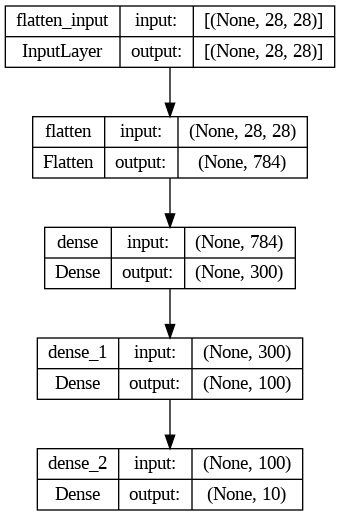

In [58]:
keras.utils.plot_model(model, "my_fashion_mnist_model.png", show_shapes=True)

In [59]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [60]:
model.get_layer(hidden1.name) is hidden1

True

Todos los parámetros de una capa pueden accesarse usando ``get_weights()`` y ``set_weights()``. Esto incluye los pesos y bias en capas densas.

In [ ]:
#el set_weigths no permite colocar pesos para tranferlearning

In [68]:
weights, biases = hidden1.get_weights()

In [69]:
weights

array([[ 0.00707652,  0.00691622, -0.02235775, ..., -0.05605988,
        -0.00109342, -0.04582525],
       [ 0.0517737 ,  0.07229128,  0.06677538, ..., -0.06872001,
        -0.03991897, -0.03770912],
       [-0.06902592, -0.05045658, -0.00280499, ..., -0.029776  ,
        -0.00680112, -0.00387207],
       ...,
       [-0.00843882, -0.00730693, -0.02860298, ..., -0.05528814,
         0.05167402, -0.05921133],
       [ 0.03829463, -0.06522696,  0.05955146, ...,  0.06345247,
         0.03727504, -0.01961249],
       [-0.03220125, -0.03300578, -0.01847451, ..., -0.00314673,
        -0.02259781,  0.01378229]], dtype=float32)

In [70]:
weights.shape # aleatorios

(784, 300)

In [71]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Los pesos son iniciados con valores aleatorios, los bias con ceros. Se puede alterar esto usando el método ``kernel_initializer`` o ``bias_initializer`` al crear la capa.

In [72]:
biases.shape#se puede iniciliar con los bayas ceros pero no los pesos

(300,)

##**Compilación del Modelo**

In [73]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [ ]:
#accuracy proporcion de clases correctamente clasificadas

En el método ``compile()`` se especifica principalmente la función de costo, el optimizador y métricas, entre otros parámetros.

- Se usa ``sparse_categorical_crossentropy`` porque se tiene etiquetas en las clases (índices de 0 a 9).
- Si tuvieramos codificaciones one_hot (por ejemplo la clase 3 codificada como [0, 0, 0, 1, 0, 0, 0, 0, 0]), entonces se usaría ``categorical_crossentropy``.
- Si estuvieramos haciendo clasificación binaria, la función de activación en la capa de salida seria "sigmoid" y la función de pérdida usada sería ``binary_crossentropy``.
- ``sgd`` indica quee entrenará el modelo usando Stochastic Gradient Descent. En ese sentido es importante tal vez hacer tuning del ``learning_rate``, que por defecti es ``lr=0.01``.
- La métrica usada para entrenamiento y validación será ``accuracy``, que en español se traduce en ``exactitud.``



##**Aprendizaje y entrenamiento**

In [74]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))
#epochs=30, 30 veces pasan los 55000 datos

Epoch 1/30
1719/1719 [==============================] - 10s 5ms/step - loss: 0.7201 - accuracy: 0.7625 - val_loss: 0.5191 - val_accuracy: 0.8264
Epoch 2/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4863 - accuracy: 0.8290 - val_loss: 0.4336 - val_accuracy: 0.8502
Epoch 3/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4395 - accuracy: 0.8437 - val_loss: 0.5450 - val_accuracy: 0.7972
Epoch 4/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4124 - accuracy: 0.8553 - val_loss: 0.3915 - val_accuracy: 0.8636
Epoch 5/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.3933 - accuracy: 0.8618 - val_loss: 0.3744 - val_accuracy: 0.8658
Epoch 6/30
1719/1719 [==============================] - 8s 4ms/step - loss: 0.3742 - accuracy: 0.8682 - val_loss: 0.3674 - val_accuracy: 0.8756
Epoch 7/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.3618 - accuracy: 0.8721 - val_loss: 0.3617 - val_accura

- Es necesario pasar las características de entrada (``X_train``) y clases objetivo (``y_train``), así como el número de épocas. También se pasa el conjunto de validación (no obligatorio).
- Otra forma de definir el conjunto de validación seria usando ``validation_split=0.1``, que indica que el 10\% será usado para validación.
- A cada época durante el entrenamiento, se despliega el número de instancias procesadas, el tiempo promedio por ejemplo, el ``loss`` y ``accuracy``, para el conjunto de entrenamiento y validación.
- Se puede observar que el ``loss`` va disminuyendo, lo que es bueno. Asimismo el accuracy en validación llega a 89\% después de 30 épocas, y que no está muy lejos del valor accuracy en entrenamiento. No parece haber overfitting.

- Se puede usar el argumento ``class_weight`` al llamar el método ``fit()``, que permite darle un peso diferente a cada clase (atenuar el desbalanceo). Estos pesos serán usados durante el cálculo del costo.


In [ ]:
#no parece haber overfiting porque la exactitud en el conjunto de entrenamiento y validadcion son
#cercanas

In [75]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 1719}

El objeto ``history``, retornado por fit, permite analizar el resultado de las métricas.

In [76]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [77]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

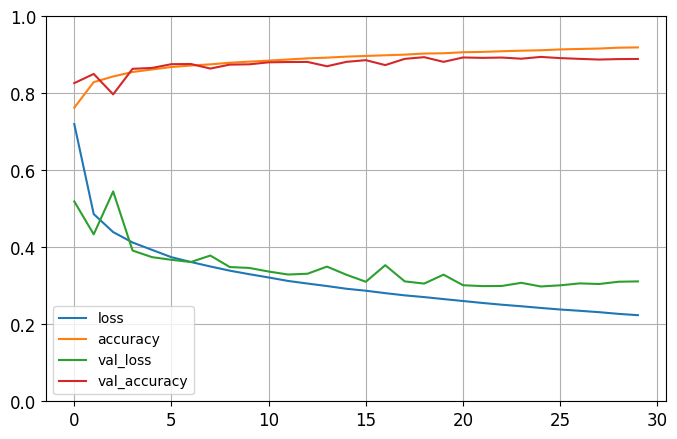

In [78]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Análisis:

- Se puede ver que tanto accuracy en validación y entrenamiento se incrementan durante el entrenamiento, mientras que el loss de validación y entrenamiento disminuyen.
- Las curvas de validación y entrenamiento son cercanas, lo que indica poco overfitting.
- Es usual que el desempeño del conjunto de entrenamiento sea mejor a la larga. En este caso más entrenamiento puede llevar a un accuracy de 89.4 \% en validación.
- Si el desempeño no es el esperado se debe ajustar hiperparámetros: ``learning_rate``, capas ocultas, número de neuronas por capa, funciones de activación, batch (32 por defecto), entre otros.



In [ ]:
#los parametros en una mlp son los pesos y los bayas
#los hiperparametros puede ser el numero de neuronas,el numero de capas y ratio de aprendizaje y
#tambien la funcion de activacion

In [80]:
model.evaluate(X_test, y_test)#el conjunto de prueba solo se usa para reportar el desempeño final

313/313 [==============================] - 1s 4ms/step - loss: 0.3448 - accuracy: 0.8778


[0.3447851538658142, 0.8777999877929688]

**Advertencia:**

- Es común tener un desempeño inferior en el conjunto de prueba (debido al afinamiento en el conjunto de validación).
- Se debe **evitar** hacer un afinamiento de los hiperparámetros sobre el conjunto de prueba, esto haría que mostraramos resultados de generalización muy optimistas.

Predicciones sobre datos nuevos

In [82]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

1/1 [==============================] - 0s 21ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.96],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [83]:
#y_pred = model.predict_classes(X_new) # deprecated
y_pred = np.argmax(model.predict(X_new), axis=-1)
y_pred

1/1 [==============================] - 0s 22ms/step


array([9, 2, 1])

In [84]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [86]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

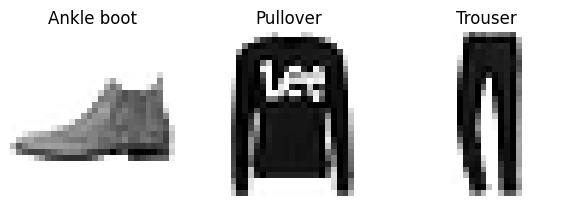

In [87]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()